<h1>First Step : Importing Libraries </h1>

In [58]:
import pandas as pd
import numpy as np
import json
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import requests
%matplotlib inline


<h1>Second Step : Gathering Data</h1>
    
    - Uploading twitter-archive-enhanced CSV File

In [59]:
archive_df = pd.read_csv('twitter_archive_enhanced.csv')
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [60]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

    - Importing image-prediction file programmatically

In [61]:
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
file_name = 'image_predictiona.tsv'

with open(file_name , mode="wb") as file:
    file.write(response.content)

    - Reading image-predictions.tsv as DataFrame

In [62]:
predictions_df = pd.read_csv(file_name,sep="\t")
predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [63]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


    - Importing tweets data from API

In [64]:
"""
consumer_key = 'hidden'
consumer_secret = 'hidden'
access_token = 'hidden'
access_secret = 'hidden'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
"""

'\nconsumer_key = \'hidden\'\nconsumer_secret = \'hidden\'\naccess_token = \'hidden\'\naccess_secret = \'hidden\'\n\nauth = OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\n\napi = tweepy.API(auth, wait_on_rate_limit=True,wait_on_rate_limit_notify=True)\n\n# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:\n# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to\n# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv\n# NOTE TO REVIEWER: this student had mobile verification issues so the following\n# Twitter API code was sent to this student from a Udacity instructor\n# Tweet IDs for which to gather additional data via Twitter\'s API\ntweet_ids = archive.tweet_id.values\nlen(tweet_ids)\n\n# Query Twitter\'s API for JSON data for each tweet ID in the Twitter archive\ncount = 0\nfails_dict = {}\nstart = timer()\n# Save each tweet\'s returned JSON as a new line in a .txt file\nwith op

In [65]:
tweets = []
with open('tweet_json.txt') as file:
    for line in file:
        tweets.append(json.loads(line))

    - Creating DataFrame from tweets list

In [66]:
tweets_df = pd.DataFrame(tweets,columns=['id','favorite_count','retweet_count'])
tweets_df.head()

,id,favorite_count,retweet_count
0,892420643555336193,34994,7343
1,892177421306343426,30298,5478
2,891815181378084864,22786,3623
3,891689557279858688,38255,7532
4,891327558926688256,36490,8112


In [67]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2329 non-null   int64
 1   favorite_count  2329 non-null   int64
 2   retweet_count   2329 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


Now we imported all needed DataFrames . next step is to assessing and cleaning dataframes

<h1>Third Step : Assessing and Cleaning Data</h1>

<h1>Define

    - First i will make copy of all dataframes and i will work on this copies

<h1>Code

In [68]:
archive_df_clean = archive_df.copy()
predictions_df_clean = predictions_df.copy()
tweets_df_clean = tweets_df.copy()

<h1>Test

In [69]:
archive_df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [70]:
predictions_df_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [71]:
tweets_df_clean.head()

,id,favorite_count,retweet_count
0,892420643555336193,34994,7343
1,892177421306343426,30298,5478
2,891815181378084864,22786,3623
3,891689557279858688,38255,7532
4,891327558926688256,36490,8112


In [72]:
#Excracting numerator and denominator correclty 
rating = archive_df_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
rating.columns = ['rating_numerator', 'rating_denominator']

#Dropping incorrect dogs names 

lower_dog_name_index = archive_df[archive_df.name.str.islower()].index


archive_df_clean.drop(lower_dog_name_index, inplace=True)
archive_df_clean.shape

(2247, 17)

In [73]:
archive_df_clean.rating_numerator.value_counts()

12      541
11      447
10      437
13      343
9       144
8        95
14       50
7        49
5        36
6        30
3        18
4        14
1         8
2         7
420       2
0         2
75        2
15        2
1776      1
960       1
121       1
99        1
45        1
27        1
17        1
20        1
24        1
26        1
44        1
50        1
80        1
84        1
88        1
144       1
182       1
143       1
666       1
165       1
Name: rating_numerator, dtype: int64

In [74]:
archive_df_clean.rating_denominator.value_counts()

10     2227
11        3
80        2
50        2
20        2
15        1
7         1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
16        1
0         1
Name: rating_denominator, dtype: int64

In [75]:
archive_df_clean.name.value_counts()

None        745
Charlie      12
Lucy         11
Cooper       11
Oliver       11
           ... 
Rey           1
Mya           1
Heinrich      1
Duddles       1
Sobe          1
Name: name, Length: 932, dtype: int64

<h1>Define

    1 -change timestamp data type to be datetime 

<h1>Code

In [76]:
#change timestamp data type to be datetime
archive_df_clean.timestamp = archive_df.timestamp.apply(pd.to_datetime)


<h1>Test

In [77]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2247 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2247 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2247 non-null   datetime64[ns, UTC]
 4   source                      2247 non-null   object             
 5   text                        2247 non-null   object             
 6   retweeted_status_id         176 non-null    float64            
 7   retweeted_status_user_id    176 non-null    float64            
 8   retweeted_status_timestamp  176 non-null    object             
 9   expanded_urls               2188 non-null   object             
 10  rating_numerator            2247 non-null   int64           

<h1>Define

    2 - change tweet_id data type to be string for tweet_id as we don't need it to be int
    

<h1>Code

In [78]:
archive_df_clean.tweet_id = archive_df.tweet_id.astype('str')

predictions_df_clean.tweet_id = predictions_df_clean.tweet_id.astype('str')

tweets_df_clean.id = tweets_df_clean.id.astype('str')


<h1>Test

In [79]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2247 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2247 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2247 non-null   datetime64[ns, UTC]
 4   source                      2247 non-null   object             
 5   text                        2247 non-null   object             
 6   retweeted_status_id         176 non-null    float64            
 7   retweeted_status_user_id    176 non-null    float64            
 8   retweeted_status_timestamp  176 non-null    object             
 9   expanded_urls               2188 non-null   object             
 10  rating_numerator            2247 non-null   int64           

In [80]:
predictions_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [81]:
tweets_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2329 non-null   object
 1   favorite_count  2329 non-null   int64 
 2   retweet_count   2329 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


<h1>Define

    3 - Change in_reply_to_status_id  and in_reply_to_user_id to string as we don't need it to be int

<h1>Code

In [82]:
#archive_df_clean.in_reply_to_status_id = archive_df_clean.in_reply_to_status_id.astype('str') # This line causing error for non-understandable reason 
archive_df_clean.in_reply_to_user_id = archive_df_clean.in_reply_to_user_id.astype('str')

<h1>Test

In [83]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2247 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2247 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         2247 non-null   object             
 3   timestamp                   2247 non-null   datetime64[ns, UTC]
 4   source                      2247 non-null   object             
 5   text                        2247 non-null   object             
 6   retweeted_status_id         176 non-null    float64            
 7   retweeted_status_user_id    176 non-null    float64            
 8   retweeted_status_timestamp  176 non-null    object             
 9   expanded_urls               2188 non-null   object             
 10  rating_numerator            2247 non-null   int64           

<h1>Define

    4 - change rating_numerator and rating_denominator to be float instead of int

<h1>Code

In [84]:
archive_df_clean.rating_numerator = archive_df_clean.rating_numerator.astype('float')
archive_df_clean.rating_denominator = archive_df_clean.rating_denominator.astype('float')

<h1>Test

In [85]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2247 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2247 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         2247 non-null   object             
 3   timestamp                   2247 non-null   datetime64[ns, UTC]
 4   source                      2247 non-null   object             
 5   text                        2247 non-null   object             
 6   retweeted_status_id         176 non-null    float64            
 7   retweeted_status_user_id    176 non-null    float64            
 8   retweeted_status_timestamp  176 non-null    object             
 9   expanded_urls               2188 non-null   object             
 10  rating_numerator            2247 non-null   float64         

In [86]:
#change id column in tweets to be tweet_id like other dataframes
tweets_df_clean.rename(columns={'id':'tweet_id'},inplace=True)


# Define

    5 - Drop retweets and replies as we don't need it in our analysis from archive and predictions dataframes

# Code

In [87]:
retweet_entries = archive_df_clean.retweeted_status_id.notnull()
archive_df_clean[retweet_entries].shape[0]

# Dropping the retweets from the archive data set
archive_df_clean = archive_df_clean[~retweet_entries]


reply_entries = archive_df_clean.in_reply_to_status_id.notnull()
archive_df_clean[reply_entries].shape[0]

# Dropping the replies from the archive data set

archive_df_clean = archive_df_clean[~reply_entries]


#check the image_prediction table for extra tweet ids not in the archive table
np.logical_not(predictions_df_clean.tweet_id.isin(list(archive_df_clean.tweet_id)))

# Dropping the retweets and replies ids from the image prediction dataframe
predictions_df_clean[~np.logical_not(predictions_df_clean.tweet_id.isin(list(archive_df_clean.tweet_id)))]

archive_df_clean.drop(columns=['retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id'],inplace=True)

<h1>Test

In [88]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1993 non-null   object             
 1   timestamp           1993 non-null   datetime64[ns, UTC]
 2   source              1993 non-null   object             
 3   text                1993 non-null   object             
 4   expanded_urls       1990 non-null   object             
 5   rating_numerator    1993 non-null   float64            
 6   rating_denominator  1993 non-null   float64            
 7   name                1993 non-null   object             
 8   doggo               1993 non-null   object             
 9   floofer             1993 non-null   object             
 10  pupper              1993 non-null   object             
 11  puppo               1993 non-null   object             
dtypes: datetime64[ns, UTC](1), float64

In [89]:
predictions_df_clean.shape

(2075, 12)

<h1>Define

    6 -Drop tweets without photos from archive dataframe using predictions dataframe

# Code

In [90]:
# creating a list of tweet_ids with images "tweets_with_image" and confirming its length
tweets_with_image = list(predictions_df_clean.tweet_id.unique())


# confirming that all the tweets with images exist in the archive dataset
len(tweets_with_image) == archive_df_clean.tweet_id.isin(tweets_with_image).sum()


archive_df_clean = archive_df_clean[archive_df_clean.tweet_id.isin(tweets_with_image)]

# Test

In [91]:
archive_df_clean.shape

(1873, 12)

# Define

    7 - Replace 'None' values with np.nan in names column

# Code

In [92]:
archive_df_clean.name.replace('None',np.nan,inplace=True)


# Test

In [93]:
archive_df_clean.sample(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
732,781524693396357120,2016-09-29 16:03:01+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Idk why this keeps happening. We only rate dog...,https://twitter.com/dog_rates/status/781524693...,12.0,10.0,NaN,None,None,None,None
237,847157206088847362,2017-03-29 18:43:12+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Daisy. She's been pup for adoption for mo...,"https://www.petfinder.com/petdetail/37334596,h...",11.0,10.0,Daisy,None,None,None,None
1786,677573743309385728,2015-12-17 19:39:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Sandy. He's sexually confused. Thinks ...,https://twitter.com/dog_rates/status/677573743...,10.0,10.0,Sandy,None,None,None,None
766,777684233540206592,2016-09-19 01:42:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...","""Yep... just as I suspected. You're not flossi...",https://twitter.com/dog_rates/status/777684233...,12.0,10.0,NaN,None,None,None,None
1542,689599056876867584,2016-01-20 00:03:21+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we see 33 dogs posing for a picture. All ...,https://twitter.com/dog_rates/status/689599056...,11.0,10.0,NaN,None,None,None,None
1573,687494652870668288,2016-01-14 04:41:12+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Marq. He stole this car. 7/10 wtf Marq...,https://twitter.com/dog_rates/status/687494652...,7.0,10.0,Marq,None,None,None,None
1129,729463711119904772,2016-05-09 00:11:16+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Pupcasso. You can't afford his art. 13/10...,https://twitter.com/dog_rates/status/729463711...,13.0,10.0,Pupcasso,None,None,None,None
1535,689977555533848577,2016-01-21 01:07:23+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Happy Wednesday here's a pup wearing a beret. ...,https://twitter.com/dog_rates/status/689977555...,12.0,10.0,NaN,None,None,None,None
1421,698195409219559425,2016-02-12 17:22:12+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Beau &amp; Wilbur. Wilbur stole Beau's be...,https://twitter.com/dog_rates/status/698195409...,9.0,10.0,Beau,None,None,None,None
1384,700796979434098688,2016-02-19 21:39:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Daniel. He's a neat pup. Exotic af. Cu...,https://twitter.com/dog_rates/status/700796979...,7.0,10.0,Daniel,None,None,None,None


# Define

    8 - in predictions dataframe we only need prediction 1 and it's confidence rate to check if the image contain a dog or 
    not

# Code

In [94]:
predictions_df_clean.drop(columns=['p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'],inplace=True,axis=1)


# Test

In [95]:
predictions_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 83.2+ KB


# Define

    9 - change p1_dog to is_dog to be more understandable 

# Code

In [96]:
predictions_df_clean.rename(columns={'p1_dog':'is_dog','p1':'prediction','p1_conf':'conf'},inplace=True)

# Test

In [97]:
predictions_df_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'prediction', 'conf', 'is_dog'], dtype='object')

# Define

    10 - Fix rating_denominator as it shouldn't be other than 10

# Code

In [98]:
#fix denominator as it shouldnt be any number but 10
archive_df_clean.rating_denominator = archive_df_clean.rating_denominator.apply(lambda x :  10)

#fix numerator as it shouldnt be below 10
archive_df_clean.rating_numerator = archive_df_clean.rating_numerator.apply(lambda x :  x + 10 if x < 10 else x)

# Test

In [99]:
#testing archive_df after fixing quality issues
archive_df_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None,None,None,None


In [100]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1873 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1873 non-null   object             
 1   timestamp           1873 non-null   datetime64[ns, UTC]
 2   source              1873 non-null   object             
 3   text                1873 non-null   object             
 4   expanded_urls       1873 non-null   object             
 5   rating_numerator    1873 non-null   float64            
 6   rating_denominator  1873 non-null   int64              
 7   name                1349 non-null   object             
 8   doggo               1873 non-null   object             
 9   floofer             1873 non-null   object             
 10  pupper              1873 non-null   object             
 11  puppo               1873 non-null   object             
dtypes: datetime64[ns, UTC](1), float64

In [101]:
#testing predictions_df after fixing quality issues
predictions_df_clean.sample(5)

,tweet_id,jpg_url,img_num,prediction,conf,is_dog
722,686003207160610816,https://pbs.twimg.com/media/CYUsRsbWAAAUt4Y.jpg,1,damselfly,0.190786,False
294,671355857343524864,https://pbs.twimg.com/media/CVEilyCUwAETbJ-.jpg,1,miniature_poodle,0.313811,True
177,669214165781868544,https://pbs.twimg.com/media/CUmGu7-UcAA0r3O.jpg,1,minivan,0.435396,False
704,684926975086034944,https://pbs.twimg.com/media/CYFZXdiU0AAc_kw.jpg,1,Labrador_retriever,0.769412,True
269,670815497391357952,https://pbs.twimg.com/media/CU83IZ8W4AEIh4y.jpg,1,American_Staffordshire_terrier,0.919714,True


In [102]:
predictions_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tweet_id    2075 non-null   object 
 1   jpg_url     2075 non-null   object 
 2   img_num     2075 non-null   int64  
 3   prediction  2075 non-null   object 
 4   conf        2075 non-null   float64
 5   is_dog      2075 non-null   bool   
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 83.2+ KB


In [103]:
#testing tweets_df_clean after fixing quality issues
tweets_df_clean.sample(5)

,tweet_id,favorite_count,retweet_count
111,870374049280663552,76432,23679
1551,687399393394311168,1824,589
2159,668981893510119424,503,276
1272,707741517457260545,2396,584
923,752334515931054080,3705,1058


In [104]:
tweets_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2329 non-null   object
 1   favorite_count  2329 non-null   int64 
 2   retweet_count   2329 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


<h1> Tidiness problems:</h1>

    1 - Merge dog stages in one column called stage

In [105]:
#Replace none in dog stages with blank
archive_df_clean.iloc[:, -4:  ] = archive_df_clean.iloc[:, -4:  ].replace('None','')

#Create stage column and add stages to it
archive_df_clean['stage'] = archive_df_clean.doggo + archive_df_clean.floofer + archive_df_clean.pupper + archive_df_clean.puppo

#drop 4 stages from dataframe
archive_df_clean.drop(columns=['doggo','floofer','pupper','puppo'],inplace = True)



    2 -Merge Three dataframes in one data with the unique identifier 'tweet_id' with a 'left' condition

In [106]:
archive_df_clean = archive_df_clean.merge(tweets_df_clean,on='tweet_id',how='left')
archive_df_clean = archive_df_clean.merge(predictions_df_clean,on='tweet_id',how='left')

In [107]:
archive_df_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,favorite_count,retweet_count,jpg_url,img_num,prediction,conf,is_dog
1306,680959110691590145,2015-12-27 03:51:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Ozzie. He was doing fine until he lost...,https://twitter.com/dog_rates/status/680959110...,19.0,10,Ozzie,,4398.0,1902.0,https://pbs.twimg.com/media/CXNAsm6WsAEST9R.jpg,2,carousel,0.500992,False
148,854010172552949760,2017-04-17 16:34:26+00:00,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",https://twitter.com/dog_rates/status/854010172...,11.0,10,NaN,doggofloofer,15370.0,2921.0,https://pbs.twimg.com/media/C9oNt91WAAAFSLS.jpg,1,English_springer,0.354733,True
1369,678334497360859136,2015-12-19 22:02:01+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Rosie. She has a snazzy bow tie and a ...,https://twitter.com/dog_rates/status/678334497...,10.0,10,Rosie,,1232.0,235.0,https://pbs.twimg.com/media/CWntoDVWcAEl3NB.jpg,1,Norfolk_terrier,0.378643,True
1156,690374419777196032,2016-01-22 03:24:22+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phred. He's an Albanian Flepperkush. T...,https://twitter.com/dog_rates/status/690374419...,11.0,10,Phred,,3126.0,805.0,https://pbs.twimg.com/media/CZSz3vWXEAACElU.jpg,1,kuvasz,0.286345,True
1745,668852170888998912,2015-11-23 18:02:38+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Bobb. Bobb is a Golden High Fescu...,https://twitter.com/dog_rates/status/668852170...,11.0,10,Bobb,,419.0,147.0,https://pbs.twimg.com/media/CUg9gBvWoAAmx-2.jpg,1,golden_retriever,0.903529,True


In [108]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1873 entries, 0 to 1872
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1873 non-null   object             
 1   timestamp           1873 non-null   datetime64[ns, UTC]
 2   source              1873 non-null   object             
 3   text                1873 non-null   object             
 4   expanded_urls       1873 non-null   object             
 5   rating_numerator    1873 non-null   float64            
 6   rating_denominator  1873 non-null   int64              
 7   name                1349 non-null   object             
 8   stage               1873 non-null   object             
 9   favorite_count      1864 non-null   float64            
 10  retweet_count       1864 non-null   float64            
 11  jpg_url             1873 non-null   object             
 12  img_num             1873 non-null 

    - Save all changes to enhanced_tweets_archive.csv

In [109]:
archive_df_clean.to_csv('twitter_archive_master.csv',index=False)

    -Insight 1 : Relation between favorites and dog stage

In [110]:
stages= archive_df_clean.groupby('stage')['favorite_count'].sum()
stages
#insight : i found that pupper got more favorites than doggo , floofer and puppo

stage
                12203924.0
doggo            1110897.0
doggofloofer       15370.0
doggopupper        96212.0
doggopuppo         43243.0
floofer            81445.0
pupper           1235864.0
puppo             445811.0
Name: favorite_count, dtype: float64

    -Insight 2 : relation between retweets and favorites

Text(0, 0.5, 'Favorites')

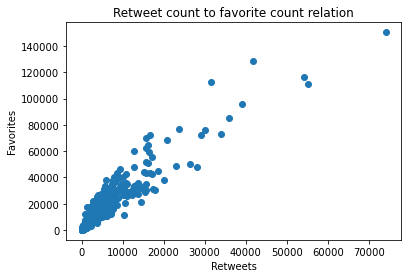

In [111]:
plt.scatter(archive_df_clean.retweet_count,archive_df_clean.favorite_count)
plt.title('Retweet count to favorite count relation')
plt.xlabel('Retweets')
plt.ylabel('Favorites')
# Insight : There is positive relationship between retweets count and favorite count
